In [144]:
%run "rossmann_01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int32         
 1   day_of_week                   1017209 non-null  int8          
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int32         
 5   open                          1017209 non-null  int8          
 6   promo                         1017209 non-null  int8          
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int8          
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

In [193]:
### Data Analisy Libraries ###
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime, time, date, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [194]:
data.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2_since_week,promo2_since_year,promo_interval,day,month,year,day_of_year,competition_open_since,promo_open_since,is_promo_month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,0,31,7,2015,212,82,24187,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13,2010,"Jan,Apr,Jul,Oct",31,7,2015,212,92,64,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14,2011,"Jan,Apr,Jul,Oct",31,7,2015,212,103,52,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,0,0,31,7,2015,212,70,24187,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,0,0,31,7,2015,212,3,24187,0


In [195]:
data=data.loc[(data['sales']>0) & (data['open'] ==1)].copy()

In [196]:
df=data[['sales','store']].set_index(data['date']).sort_index(ascending=True)

## Avarage Sales of Stores by day, month, year

In [211]:
dados = df.resample('D').mean().drop('store',axis=1)

In [200]:
dados.fillna(0, inplace=True)

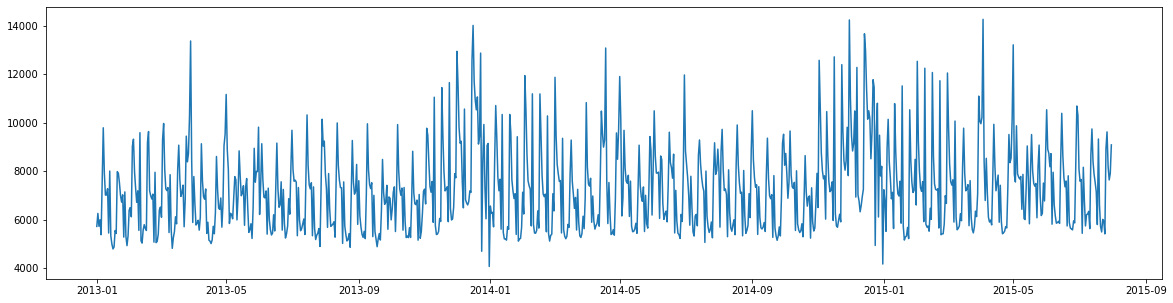

In [214]:
plt.figure(figsize=(20,5))
plt.plot(dados)

<AxesSubplot:xlabel='day'>

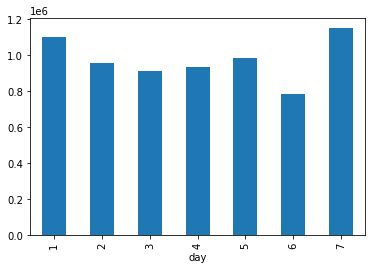

In [202]:
dados['sales'].groupby(dados.index.isocalendar().day).sum().plot(kind='bar')

<AxesSubplot:xlabel='date'>

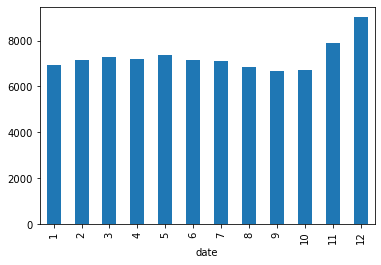

In [210]:
dados['sales'].groupby(dados.index.month).mean().plot(kind='bar')

## Mean All Stores

In [178]:
dados['sales'].groupby(dados.index.month).mean().plot(kind='bar')

KeyError: 'sales'

<AxesSubplot:xlabel='day'>

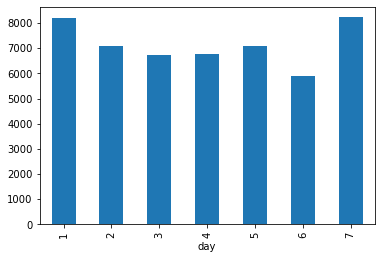

In [179]:
df['sales'].groupby(df.index.isocalendar().day).mean().plot(kind='bar')

<AxesSubplot:xlabel='day'>

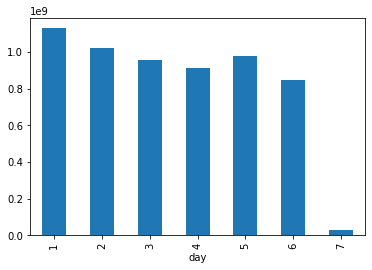

In [151]:
df['sales'].groupby(df.index.isocalendar().day).sum().plot(kind='bar')

In [152]:
#data_prep=data_prep.set_index(data_prep['date'])
#data_prep=data_prep.sort_index()

In [204]:
resultado = seasonal_decompose(dados['sales'], period=12)

In [205]:
tendencia= resultado.trend
seasom=resultado.seasonal
resultado.resid


date
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
              ..
2015-07-27   NaN
2015-07-28   NaN
2015-07-29   NaN
2015-07-30   NaN
2015-07-31   NaN
Freq: D, Name: resid, Length: 942, dtype: float64

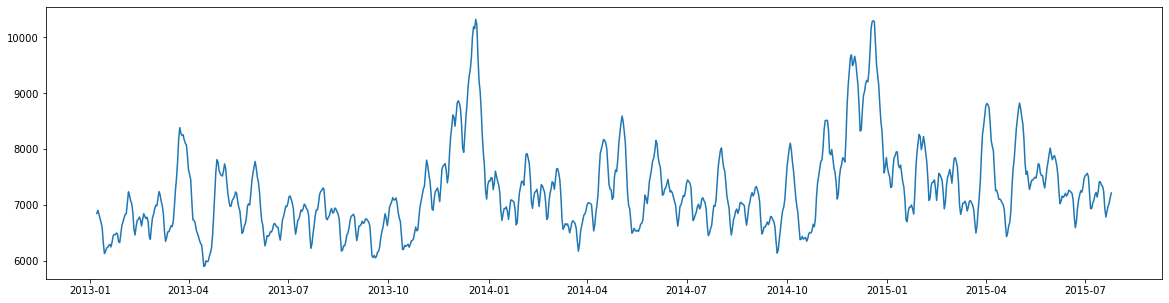

In [209]:
plt.figure(figsize=(20,5))
plt.plot(tendencia)

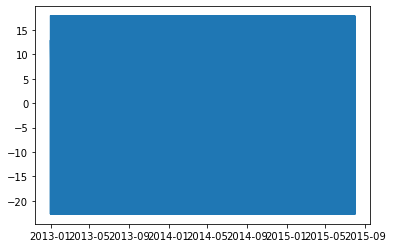

In [164]:
plt.plot(seasom)

KeyboardInterrupt: 

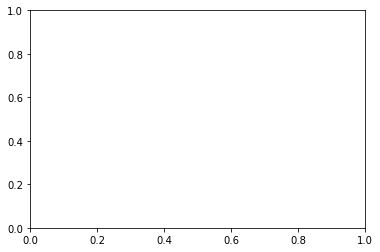

In [165]:
plot_acf(df.sales, lags=6*7)
plt.show()

na média o mês de dezembro é o mais lucrativo e o de janeiro o menos.
Segunda é o dia mais lucrativo, exceto quando comparado com as lojas que abrem aos domingos, no entanto são poucas as lojas da Rossman que abre aos domingos.


## Mean Best Store

<AxesSubplot:xlabel='date'>

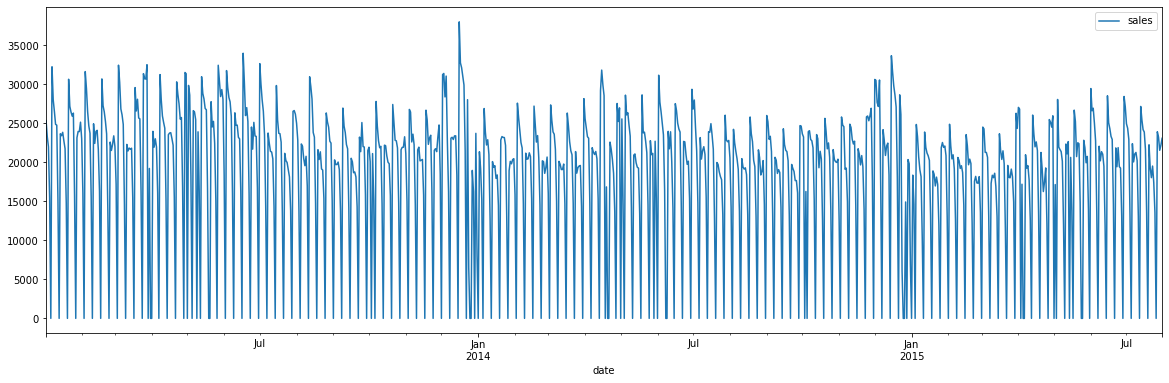

In [129]:
store_817 = df.loc[(df['store']== 817),['sales']]
store_817 = store_817.resample('D').sum()
store_817.plot(figsize=(20,6))

<AxesSubplot:xlabel='date'>

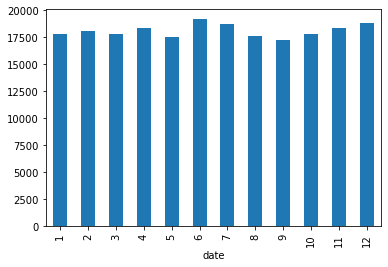

In [130]:
store_817['sales'].groupby(store_817.index.month).mean().plot(kind='bar')

<AxesSubplot:xlabel='day'>

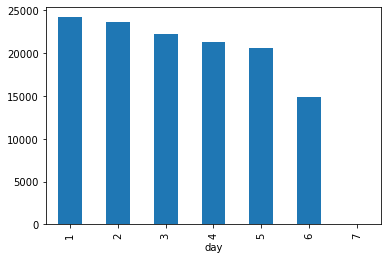

In [131]:
store_817['sales'].groupby(store_817.index.isocalendar().day).mean().plot(kind='bar')

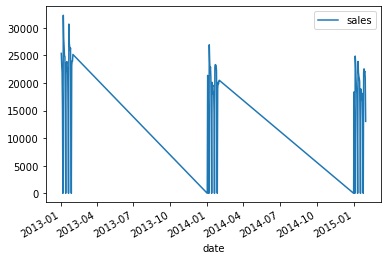

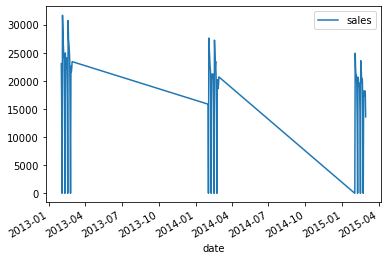

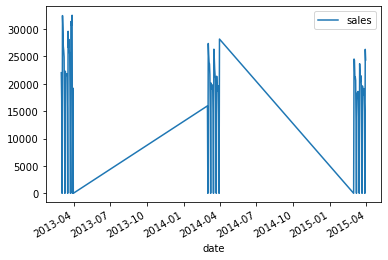

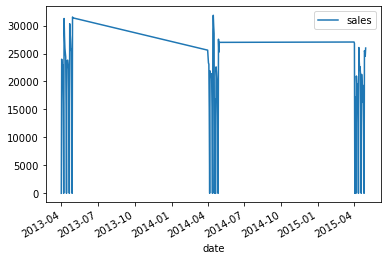

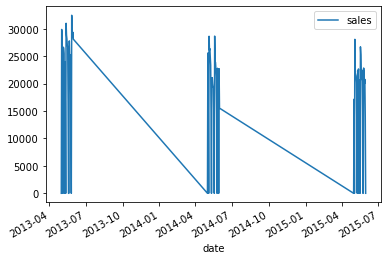

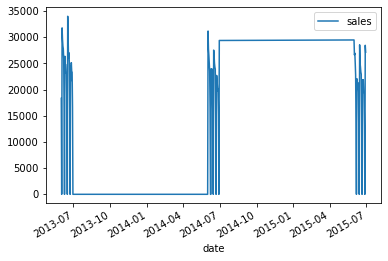

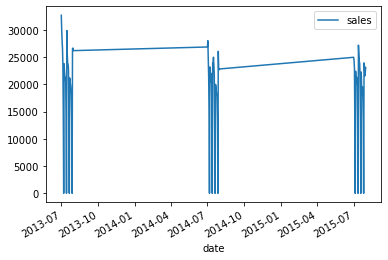

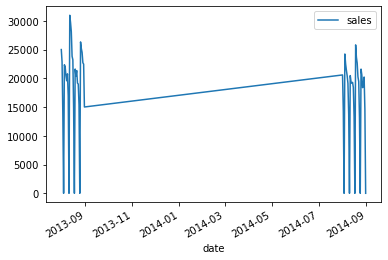

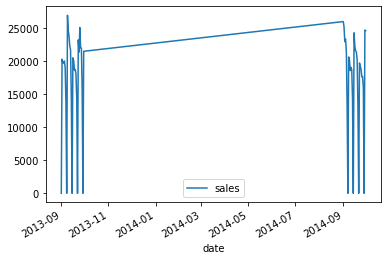

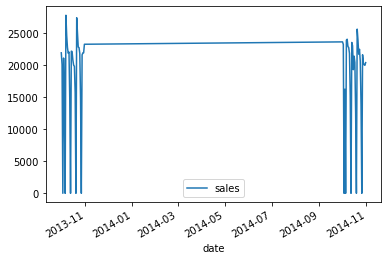

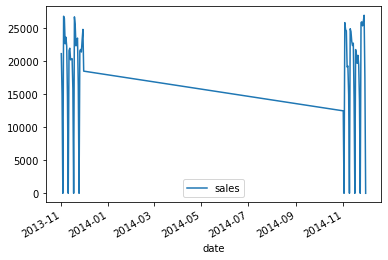

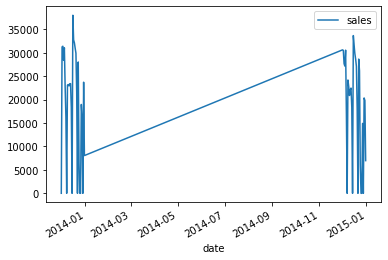

In [132]:
store_817.groupby(store_817.index.month).plot()
store_817_w=store_817.resample("M")

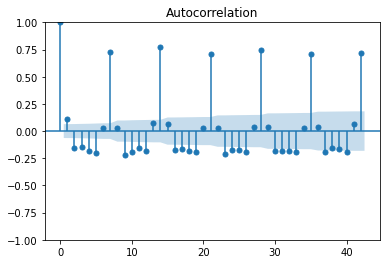

In [139]:
plot_acf(store_817.sales, lags=6*7)
plt.show()

C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


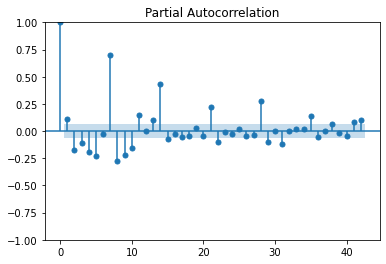

In [140]:
plot_pacf(store_817.sales, lags=6*7)
plt.show()

In [135]:
train = store_817.loc[store_817.index < '2015-06-19']
test = store_817.loc[store_817.index >= '2015-06-19']

y_train = train.index.values
X_train = train.values#default_features, ts_features

y_test = test.values
X_test = test.index.values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((898, 1), (898,), (43,), (43, 1))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 784 entries, 2013-01-02 to 2015-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   784 non-null    int64
dtypes: int64(1)
memory usage: 12.2 KB


### SARIMAX

In [138]:
sarima = SARIMAX(X_train, freq='M', order=(1,1,1), seasonal_order=(0,1,1,12)).fit()

ValueError: Frequency provided without associated index.

In [137]:
arima = ARIMA(store_817['sales'], freq='MS').fit()

ValueError: The given frequency argument is incompatible with the given index.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
train['sales'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['sales'].plot(ax=ax, label='Test Set')
#ax.axvline('2015-06-19', color='black', ls='--')
#ax.legend(['Training Set', 'Test Set'])
#plt.legend(loc='best', prop={'size': 10})

In [ ]:
data_prep['sales'].loc[data_prep['sales']< 6.4].plot(style='.', figsize=(20, 5), title='Outliers');
outlier_inf= (data_prep['sales']< 6.4)
data_prep=data_prep[~outlier_inf]

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=6*7*1115, gap=0)

In [ ]:
# df = data_prep.set_index(data_prep['date'])
# df = df.sort_index()

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data_prep):
    train = data_prep.iloc[train_idx]
    test = data_prep.iloc[val_idx]
    train['sales'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['sales'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
def add_lags(df):
    target_map = df['sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df

In [ ]:
data_prep = add_lags(data_prep)

In [ ]:
data_prep.columns

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=6*7*1115, gap=0)
data_prep = data_prep.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data_prep):
    train = data_prep.iloc[train_idx]
    test = data_prep.iloc[val_idx]

    ts_features = ['store',
                     'day_of_week',
                     'day',
                     'month',
                     'year',
                     'dayofyear',
                     'competition_distance',
                     'competition_open_since',
                     'promo',
                     'is_promo_month',
                     'promo2',
                     #'competition_open_since_month','competition_open_since_year',
                     'promo2_since_week',
                     'school_holiday', 
                     #'state_holiday_Christmas',
                     #'state_holiday_Easter Holiday',
                     #'state_holiday_Public Holiday',
                     #'state_holiday_Regular Day',                     
                     'assortment',
                      'store_type',
                     #'store_type_a',
                     #'store_type_b',
                     #'store_type_c',
                     #'store_type_d'
                      'lag1',
                      'lag2',
                      'lag3'
                    ]

    X_train = train[ts_features]
    y_train = train[target]
    X_test = test[ts_features]
    y_test = test[target]
   
    xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=20)
    y_pred = xgb.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(np.mean((y_test)/((y_pred)-1) ** 2))#np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)   
    

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

In [ ]:
# Retrain on all data
#df = create_features(df)

X_all = data_prep[ts_features]
y_all = data_prep[target]

xgb.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=20)

In [ ]:
data_prep.index.max()

In [ ]:
future = pd.date_range('2014-07-31','2015-09-30', freq='D')

In [ ]:
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
data_prep['isFuture'] = False
df_and_future = pd.concat([data_prep, future_df])
#df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
df_and_future